<a href="https://colab.research.google.com/github/abduhsalam/Hate-Speech-Detection/blob/main/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Detection 

Abduh Salam DS0101

Dataset

The dataset is a two columns data of: label - tweet, consist of 713 tweets in Indonesian.

The label is Non_HS or HS. Non_HS for "non-hate-speech" tweet and HS for "hate-speech" tweet.

- Number of Non_HS tweets: 453
- Number of HS tweets: 260

Since this dataset is unbalanced, you might have to do over-sampling/down-sampling in order to create a balanced dataset.

Install Liblary

In [21]:
! pip3 install nltk
! pip3 install Sastrawi
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
#read dataset
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/abduhsalam/Hate-Speech-Detection/main/IDHSD_RIO_unbalanced_713_2017.txt', sep='\t', encoding = "ISO-8859-1", dtype=str)
df.head()

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


In [23]:
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Case Folding
# Convert text to lowercase
df['Tweet'] = df['Tweet'].str.lower()

# Remove Twitter Post Link and RT word
df['Tweet'] = df['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'rt', '', regex=True)

# Remove number
df['Tweet'] = df['Tweet'].str.replace('\d+', '')

# Remove Punctuation
df['Tweet'] = df['Tweet'].str.replace('[^\w\s]','')

# Remove Whitespaces
df["Tweet"] = df['Tweet'].str.strip()

# Tokenization
df["Tweet"] = df["Tweet"].apply(nltk.word_tokenize)

# StopWords Removal
stop_words = set(stopwords.words('indonesian'))
df["Tweet"] = df["Tweet"].apply(lambda x: [item for item in x if item not in stop_words])

# Stemming Indonesian
factory = StemmerFactory()
stemmer = factory.create_stemmer()
df["Tweet"] = df["Tweet"].apply(lambda x: [ stemmer.stem(item) for item in x])

df.head()

,Label,Tweet
0,Non_HS,"[spardaxyz, fadli, zon, mendagri, nonaktif, ah..."
1,Non_HS,"[baguscondromowo, luka, aksi, rangka, penjara,..."
2,Non_HS,"[sylvi, gurbernur, keras, perempuan, bukti, fo..."
3,Non_HS,"[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,Non_HS,"[lisdaulay, waspada, ktp, palsukawal, pilkada]"


# Hate Speech Tweet Word Cloud 

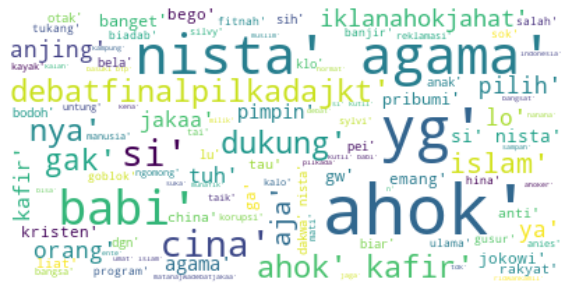

In [47]:
from os import path
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Create and generate a word cloud image:
word = df.Tweet[df['Label']=='HS'].astype('string')
word.head()
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_text(' '.join(word))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From this hate speech word cloud , can be concluded that a tweet containing hate speech contains words related to religion, race, dirty words and elections.

# Split into Data Train 75% and Data Test 25%

In [28]:
# Set Training and Testing Data (70:30)
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test  = train_test_split(df['Tweet'] , df['Label'], shuffle = True, test_size=0.25, random_state=1)

# Show the Training and Testing Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(534,)
(179,)
(534,)
(179,)


# SVM Modelling

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
warnings.filterwarnings('ignore')

# pipeline combining transformers and estimator
svm = make_pipeline(TfidfVectorizer(lowercase=False, preprocessor=' '.join), SVC(random_state=1, probability=True))

# grid searh to choose the best (combination of) hyperparameters
r=[0.1,1]
pg_svm = [{'svc__C':r, 'svc__kernel':['linear']}]

gs_svm = GridSearchCV(estimator= svm,                    
                    param_grid= pg_svm,
                    scoring='accuracy',
                    cv=2)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_svm_scores = cross_val_score(gs_svm, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_svm.fit(X_train, y_train)
gs_svm_best=gs_svm.best_estimator_
gs_svm_best.fit(X_train, y_train)

y_pred_svm = gs_svm_best.predict(X_test)

acc_svm = metrics.accuracy_score(y_test, y_pred_svm)
prec_svm = metrics.precision_score(y_test, y_pred_svm, pos_label='Non_HS')
rec_svm = metrics.recall_score(y_test, y_pred_svm, pos_label='Non_HS')
f1_svm = metrics.f1_score(y_test, y_pred_svm, pos_label='Non_HS')
kappa_svm = metrics.cohen_kappa_score(y_test, y_pred_svm)

print("Accuracy:", acc_svm)
print("Precision:", prec_svm)
print("Recall:", rec_svm)
print("F1 Score:", f1_svm)
print("Cohens Kappa Score:", kappa_svm)

# Visualize ROC Curve
y_pred_svm_proba = gs_svm_best.predict_proba(X_test)[::,1]
fprsvm, tprsvm, _ = metrics.roc_curve(y_test,  y_pred_svm_proba, pos_label="Non_HS")
aucsvm = metrics.roc_auc_score(y_test, y_pred_svm_proba)

Accuracy: 0.888268156424581
Precision: 0.8888888888888888
Recall: 0.9369369369369369
F1 Score: 0.9122807017543859
Cohens Kappa Score: 0.7587275913195848


# ANN Modelling

In [66]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from scipy import stats
warnings.filterwarnings('ignore')

# pipeline combining transformers and estimator
ann = make_pipeline(TfidfVectorizer(lowercase=False, preprocessor=' '.join), MLPClassifier())

# grid searh to choose the best (combination of) hyperparameters
parameter_space = {
    'mlpclassifier__hidden_layer_sizes': [(10,30,10),(20,)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.05],
    'mlpclassifier__learning_rate': ['constant','adaptive'],
}

gs_ann = GridSearchCV(estimator=ann, 
                      param_grid=parameter_space,
                      scoring='accuracy',
                      cv=2,
                    )

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_ann_scores = cross_val_score(gs_ann, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_ann.fit(X_train, y_train)
gs_ann_best=gs_ann.best_estimator_
gs_ann_best.fit(X_train, y_train)

y_pred_ann = gs_ann_best.predict(X_test)

acc_ann = metrics.accuracy_score(y_test, y_pred_ann)
prec_ann = metrics.precision_score(y_test, y_pred_ann, pos_label='Non_HS')
rec_ann = metrics.recall_score(y_test, y_pred_ann, pos_label='Non_HS')
f1_ann = metrics.f1_score(y_test, y_pred_ann, pos_label='Non_HS')
kappa_ann = metrics.cohen_kappa_score(y_test, y_pred_ann)

print("Accuracy:", acc_ann)
print("Precision:", prec_ann)
print("Recall:", rec_ann)
print("F1 Score:", f1_ann)
print("Cohens Kappa Score:", kappa_ann)

# Visualize ROC Curve
y_pred_ann_proba = gs_ann_best.predict_proba(X_test)[::,1]
fprann, tprann, _ = metrics.roc_curve(y_test,  y_pred_ann_proba, pos_label="Non_HS")
aucann = metrics.roc_auc_score(y_test, y_pred_ann_proba)

Accuracy: 0.8715083798882681
Precision: 0.8666666666666667
Recall: 0.9369369369369369
F1 Score: 0.9004329004329005
Cohens Kappa Score: 0.7201033380923244


#  KNN Modelling

In [30]:
# Import Module
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling KNN Classifier
pipe_knn= make_pipeline(TfidfVectorizer(lowercase=False, preprocessor=' '.join), KNeighborsClassifier())
gs_knn=GridSearchCV(estimator= pipe_knn,
                    param_grid={'kneighborsclassifier__n_neighbors':[4,5,6,7,8]},
                    scoring='accuracy',
                    cv=10)
gs_knn_scores = cross_val_score(gs_knn, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)
gs_knn.fit(X_train, y_train)
gs_knn_best=gs_knn.best_estimator_
gs_knn_best.fit(X_train, y_train)

# Predict to Test Data
y_pred_knn = gs_knn_best.predict(X_test)

# Show the Accuracy, Precision, Recall
acc_gs_knn = metrics.accuracy_score(y_test, y_pred_knn)
prec_gs_knn = metrics.precision_score(y_test, y_pred_knn, pos_label='Non_HS')
rec_gs_knn = metrics.recall_score(y_test, y_pred_knn, pos_label='Non_HS')
f1_gs_knn = metrics.f1_score(y_test, y_pred_knn, pos_label='Non_HS')
kappa_gs_knn = metrics.cohen_kappa_score(y_test, y_pred_knn)

print("Accuracy:", acc_gs_knn)
print("Precision:", prec_gs_knn)
print("Recall:", rec_gs_knn)
print("F1 Score:", f1_gs_knn)
print("Cohens Kappa Score:", kappa_gs_knn)

# ROC Curve
y_pred_knn_proba = gs_knn_best.predict_proba(X_test)[::,1]
fprknn, tprknn, _ = metrics.roc_curve(y_test,  y_pred_knn_proba, pos_label="Non_HS")
aucknn = metrics.roc_auc_score(y_test, y_pred_knn_proba)

Accuracy: 0.8379888268156425
Precision: 0.8416666666666667
Recall: 0.9099099099099099
F1 Score: 0.8744588744588745
Cohens Kappa Score: 0.6470868175946699


# Compare ROC Curve 

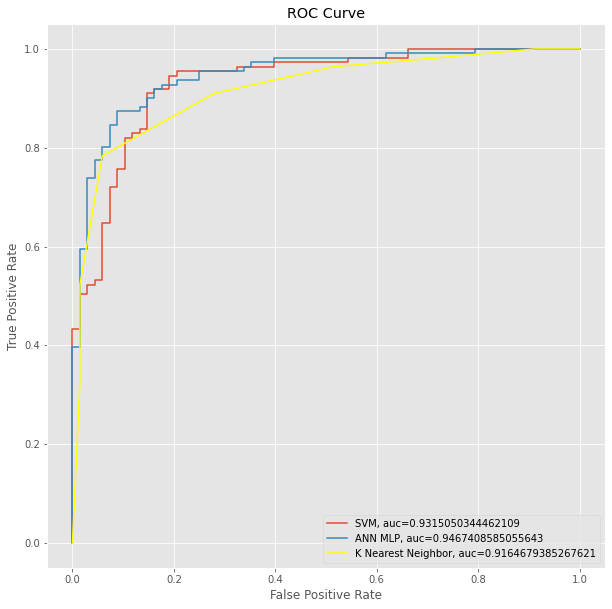

In [68]:
# Set Size and Style
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

# Comparing ROC Curve
plt.plot(fprsvm,tprsvm,label="SVM, auc="+str(aucsvm))
plt.plot(fprann,tprann,label="ANN MLP, auc="+str(aucann))
plt.plot(fprknn,tprknn,label="K Nearest Neighbor, auc="+str(aucknn), color='yellow')

# plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

eng

concluded that the ANN Algorithm has the best performance.
However, since data set has a contextual case during elections and the Ahok blasphemy case, data are less general and causes the model less effective to be implemented in general cases.
To improve performance it will better if the add data and add preprocessing such as fixing typos, removing accents and lemmatizer.


ind

Dapat disumpulkan bahwa Algoritma ANN memiliki performansi yang terbaik.
akan tetapi karena dataset ini memiliki konteks saat pemilu dan kasus penistaan ahok, dataset ini kurang bersifat general dan menyebabkan model yang dibangun kurang efektif untuk diimplementasikan pada kasus lebih general.
untuk meningkatkan performansi akan lebih jika dataset ditambah dan melakukan preprocessing seperti perbaikan typo, remove accents dan lemmatizer.
